!cat Data/train.csv.gz | gzip -d | awk -F',' '$6==7440663949' > Data/example.txt

In [29]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [30]:
example = pd.read_csv('Data/example.txt'
                      , sep=','
                      , header=None
                      , index_col=0)

In [31]:
example.columns = ['X','Y','accuracy','timestamp','place_id']

#### test with means

In [32]:
mean_x, mean_y = np.mean(example['X']), np.mean(example['Y'])

#### test with weighted calculation

In [33]:
example['weighted_accuracy'] = 1/(example['accuracy']*np.sum(1/example['accuracy']))

In [34]:
weighted_x = np.sum(example['X']*example['weighted_accuracy'])
weighted_y = np.sum(example['Y']*example['weighted_accuracy'])

#### median 

In [35]:
median_x = np.median(example['X'])
median_y = np.median(example['Y'])

#### gather range stats

In [36]:
min_x, max_x = np.min(example['X']), np.max(example['X'])
min_y, max_y = np.min(example['Y']), np.max(example['Y'])

#### plot examples

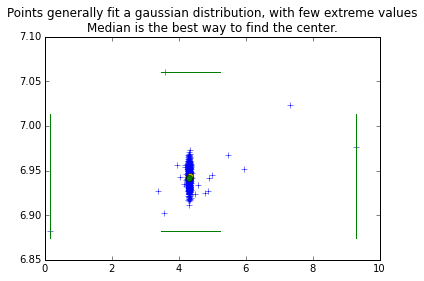

In [37]:
plt.plot(example['X'],example['Y'],'+')
plt.plot(mean_x, mean_y,'ro')
plt.plot(weighted_x, weighted_y,'yo')
plt.plot(median_x, median_y,'go')
plt.plot([min_x]*3, [weighted_y*.99,weighted_y,weighted_y*1.01],'g-')
plt.plot([max_x]*3, [weighted_y*.99,weighted_y,weighted_y*1.01],'g-')
plt.plot([weighted_x*.8,weighted_x,weighted_x*1.2], [min_y]*3,'g-')
plt.plot([weighted_x*.8,weighted_x,weighted_x*1.2],[max_y]*3,'g-')
plt.title('Points generally fit a gaussian distribution, with few extreme values \
\nMedian is the best way to find the center.')

#### times

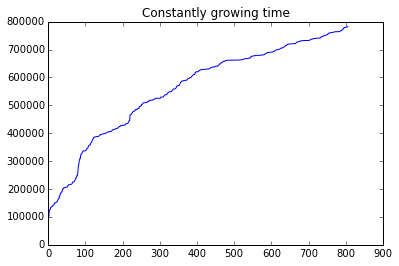

In [38]:
plt.plot(xrange(example.shape[0]),example['timestamp'].sort_values(),'-')
plt.title('Constantly growing time')

In [39]:
mn, mx = np.min(example['timestamp']),np.max(example['timestamp'])
print 'Example min: {}, max: {}'.format(mn,mx)

Example min: 95814, max: 782788


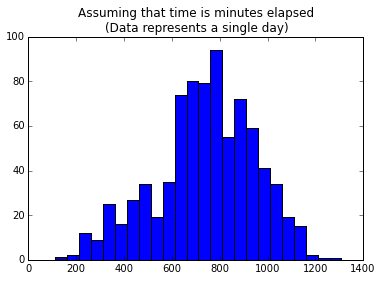

In [40]:
example['time_mod'] = example['timestamp'] % (60*24)
_ = plt.hist(example['time_mod'].ravel(), 24)
plt.title('Assuming that time is minutes elapsed \
\n(Data represents a single day)')

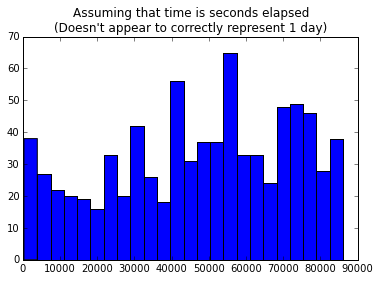

In [41]:
example['time_mod'] = example['timestamp'] % (3600*24)
_ = plt.hist(example['time_mod'].ravel(), 24)
plt.title('Assuming that time is seconds elapsed \
\n(Doesn\'t appear to correctly represent 1 day)')

#### time for all training data

In [22]:
!cat Data/train.csv.gz | gzip -d | awk '\
BEGIN { min=1000000; max=0; rowcnt=0;} \
{ \
  if (NR>1) { \
      split($0,a,","); \
      if (a[5]<min) { \
        min=a[5]; \
      } \
      if (a[5]>max) { \
        max=a[5]; \
      } \
      rowcnt+=1; \
   } \
} \
END { print min, max, rowcnt; }'

1 786239 29118021


In [23]:
mx = 786239
mn = 1
print '''
If the dataset is elapsed seconds from the 
first record, the total elapsed time 
in the dataset is {} days 
for {} million records.

If the time were minutes elapsed, 
the total elapsed time would be {} days.

If the time were miliseconds elapsed,
the total elapsed time would be {} hours.
'''.format(
    round((mx-mn)*1.0/3600/24,1)
    , round(29118021*1.0 / 1000000,2)
    , (mx-mn)/60/24
    , round((mx-mn)*1.0/(3600*1000),4)
)


If the dataset is elapsed seconds from the 
first record, the total elapsed time 
in the dataset is 9.1 days 
for 29.12 million records.

If the time were minutes elapsed, 
the total elapsed time would be 545 days.

If the time were miliseconds elapsed,
the total elapsed time would be 0.2184 hours.



In [24]:
!cat Data/train.csv.gz | gzip -d | awk -F, '{print int($5%(24*60));}' \
| sort | uniq -c| sort -k2,2n > time.txt

In [25]:
tm = pd.read_csv('time.txt',sep='\s',header=None)

/Library/Python/2.7/site-packages/IPython/kernel/__main__.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators; you can avoid this warning by specifying engine='python'.
  if __name__ == '__main__':


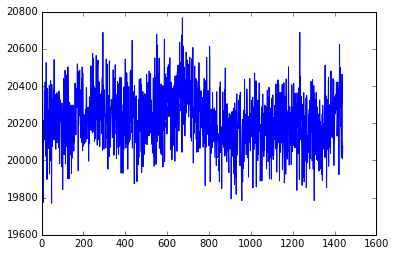

In [26]:
plt.plot(tm.iloc[:,1],tm.iloc[:,0])

### Version 1

#### MR job

In [117]:
%%writefile process_places.py
from mrjob.job import MRJob
from mrjob.step import MRStep
from math import sqrt

class ProcessPlaces(MRJob):
    ''' Map-reduce job will read through 
        training data and create a file 
        with relevant metrics for each unique place_id
        
        The metrics are then used later in the 
        single-core python code 
    '''
    def mapper(self, _, line):
        ''' send data with place id '''
        fields = line.split(',')
        place_id = fields[-1]
        row_id = fields[0]
        x = fields[1]
        y = fields[2]
        accuracy = fields[3]
        time = fields[4]
        if row_id!='row_id':
            yield place_id, {'row_id':row_id
                             , 'x':float(x)
                             , 'y':float(y)
                             , 'accuracy':float(accuracy)
                             , 'time':int(time)
                             , 'time_hr':int(time)%(24*60)//60
                            }
    
    def reducer(self, place_id, data_list):
        ''' aggregate place data '''
        def median(lst):
            ''' Calculate the median
                of a list of numbers
            '''
            lst = sorted(lst)
            n = len(lst)
            if n%2!=0:
                i = n/2
                return lst[i]*1.0
            else:
                i1 = n/2-1
                i2 = i1+1
                return (lst[i1]+lst[i2])*1.0/2
        
        # save generator as list object
        # need to loop twice
        dl = list(data_list)
        
        # calculate base metrics
        n = 0
        acc_sum = 0
        inv_sum = 0
        x_sum = 0
        y_sum = 0
        time_sum = 0
        time_hours = {}
        for d in dl:
            n += 1
            
            # average accuracy 
            acc_sum += d['accuracy']
            
            # average inverse of accuracy
            inv_sum += 1.0/d['accuracy']
            
            # average of x 
            x_sum += d['x']
            
            # average of y
            y_sum += d['y']
            
            # average hour
            time_sum += d['time_hr']
            
            # distribution of hours
            if d['time_hr'] not in time_hours:
                time_hours[d['time_hr']]=0
            time_hours[d['time_hr']]+=1
        
        # calculate centers and standard deviations
        mean_x = x_sum/n
        mean_y = y_sum/n
        mean_time = time_sum/n
        mean_acc = acc_sum/n
        center_x, center_y = 0, 0
        weighted_x, weighted_y = 0, 0
        sd_x, sd_y = 0, 0
        sd_time = 0
        sd_acc = 0
        xs = []
        ys = []
        for d in dl:
            xs.append(d['x'])
            ys.append(d['y'])
            inv_a = (1.0/d['accuracy'])/inv_sum
            weighted_x += d['x']*inv_a
            weighted_y += d['y']*inv_a
            sd_x += (d['x']-mean_x)**2
            sd_y += (d['y']-mean_y)**2
            sd_time += (d['time_hr']-mean_time)**2
            sd_acc += (d['accuracy']-mean_acc)**2
            n += 1
        sd_x /= n
        sd_y /= n
        sd_time /= n
        sd_acc /= n
        sd_x = sqrt(sd_x)
        sd_y = sqrt(sd_y)
        sd_time = sqrt(sd_time)
        sd_acc = sqrt(sd_acc)
        
        # calculate medians
        center_x = median(xs)
        center_y = median(ys)
        
        # calculate unit value of accuracy
        unit_acc = [0,0]
        for d in dl:
            unit_acc[0] += abs(d['x']-center_x)/d['accuracy']/n
            unit_acc[1] += abs(d['y']-center_y)/d['accuracy']/n
        unit_acc[0] = round(unit_acc[0],6)
        unit_acc[1] = round(unit_acc[1],6)
        
        yield None, '|'.join(map(str,[
                    place_id
                    , round(center_x,4) 
                    , round(center_y,4)
                    , round(sd_x,4)
                    , round(sd_y,4)
                    , int(mean_time)
                    , round(sd_time,2)
                    , round(sd_acc,4)
                    , int(n)
                    , unit_acc
                    , time_hours
                ]))
    
if __name__ == '__main__':
    ProcessPlaces.run()

Overwriting process_places.py


In [70]:
!python process_places.py --strict-protocols Data/example.txt > Data/processed_places_ex.txt

no configs found; falling back on auto-configuration
no configs found; falling back on auto-configuration
creating tmp directory /var/folders/f8/70g84lyd3n387wjwhbfq4dp80000gn/T/process_places.bshur.20160618.075007.434889
writing to /var/folders/f8/70g84lyd3n387wjwhbfq4dp80000gn/T/process_places.bshur.20160618.075007.434889/step-0-mapper_part-00000
Counters from step 1:
  (no counters found)
writing to /var/folders/f8/70g84lyd3n387wjwhbfq4dp80000gn/T/process_places.bshur.20160618.075007.434889/step-0-mapper-sorted
> sort /var/folders/f8/70g84lyd3n387wjwhbfq4dp80000gn/T/process_places.bshur.20160618.075007.434889/step-0-mapper_part-00000
writing to /var/folders/f8/70g84lyd3n387wjwhbfq4dp80000gn/T/process_places.bshur.20160618.075007.434889/step-0-reducer_part-00000
Counters from step 1:
  (no counters found)
Moving /var/folders/f8/70g84lyd3n387wjwhbfq4dp80000gn/T/process_places.bshur.20160618.075007.434889/step-0-reducer_part-00000 -> /var/folders/f8/70g84lyd3n387wjwhbfq4dp80000gn/T/pro

In [118]:
!head Data/processed_places_ex.txt

null	"5662813655|5.8454|6.7676|0.956|0.0221|10|5.2|124.5537|1226|[0.059146, 0.001044]|{0: 25, 1: 25, 2: 28, 3: 28, 4: 53, 5: 30, 6: 32, 7: 37, 8: 28, 9: 20, 10: 29, 11: 23, 12: 22, 13: 22, 14: 19, 15: 21, 16: 11, 17: 7, 18: 7, 19: 17, 20: 14, 21: 38, 22: 35, 23: 42}"


In [87]:
!python process_places.py \
--strict-protocols \
Data/train.csv.gz \
> Data/processed_places.txt

no configs found; falling back on auto-configuration
no configs found; falling back on auto-configuration
creating tmp directory /var/folders/f8/70g84lyd3n387wjwhbfq4dp80000gn/T/process_places.bshur.20160618.081426.786136
writing to /var/folders/f8/70g84lyd3n387wjwhbfq4dp80000gn/T/process_places.bshur.20160618.081426.786136/step-0-mapper_part-00000
Counters from step 1:
  (no counters found)
writing to /var/folders/f8/70g84lyd3n387wjwhbfq4dp80000gn/T/process_places.bshur.20160618.081426.786136/step-0-mapper-sorted
> sort /var/folders/f8/70g84lyd3n387wjwhbfq4dp80000gn/T/process_places.bshur.20160618.081426.786136/step-0-mapper_part-00000
writing to /var/folders/f8/70g84lyd3n387wjwhbfq4dp80000gn/T/process_places.bshur.20160618.081426.786136/step-0-reducer_part-00000
Counters from step 1:
  (no counters found)
Moving /var/folders/f8/70g84lyd3n387wjwhbfq4dp80000gn/T/process_places.bshur.20160618.081426.786136/step-0-reducer_part-00000 -> /var/folders/f8/70g84lyd3n387wjwhbfq4dp80000gn/T/pro

In [119]:
!head -n2 Data/processed_places.txt

null	"1000015801|2.6915|5.5492|0.1464|0.0112|16|3.74|82.1417|156|[0.002306, 0.000384]|{0: 3, 1: 1, 11: 2, 13: 15, 14: 12, 15: 7, 16: 3, 17: 4, 18: 3, 19: 2, 20: 2, 21: 3, 22: 8, 23: 13}"
null	"1000017288|7.1079|4.347|0.2382|0.0072|12|2.83|41.1274|190|[0.007823, 0.000173]|{0: 1, 1: 2, 3: 1, 4: 1, 5: 1, 6: 1, 7: 2, 8: 4, 9: 3, 10: 1, 11: 12, 12: 11, 13: 13, 14: 13, 15: 7, 16: 11, 17: 7, 20: 1, 22: 1, 23: 2}"


#### process file

In [150]:
%%writefile find_nearest_neighbors.py
#!/usr/bin/env python
from math import sqrt 
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
import scipy as sp
import os
import logging
import time
from cStringIO import StringIO
logging.basicConfig()


PLACES_FILE = 'Data/processed_places.txt'
TEST_FILE = 'Data/test.csv'
OUTPUT_FILE = 'Data/submission.csv'


def gather_places():
    ''' Loop through places file 
        and store in memory
    '''
    places = []
    with open(PLACES_FILE,'r') as r:
        for line in r:
            _, line = line.replace('"','').split('\t')
            fields = line.split('|')
            place_id = fields[0]
            field_names = [
                'center_x'
                , 'center_y'
                , 'sd_x'
                , 'sd_y'
                , 'mean_time'
                , 'sd_time'
                , 'sd_acc'
                , 'n'
            ]
            fields_with_names = zip(field_names,fields[1:-2])
            d = {k: float(v) for k,v in fields_with_names}
            d['time_hours'] = eval(fields[-1])
            d['unit_acc'] = eval(fields[-2])
            d['place_id'] = place_id
            places.append(d)
    return places


def build_kd_tree(places):
    ''' Build a KD tree
        for efficient NN search
    '''
    p_df = pd.DataFrame(places)
    p_df['unit_acc_x'] = p_df['unit_acc'].apply(lambda x: x[0])
    p_df['unit_acc_y'] = p_df['unit_acc'].apply(lambda x: x[1])
    tree = sp.spatial.KDTree(p_df[['center_x','center_y']])
    return p_df, tree


def dumplines(p):
    p.seek(0)
    with open(OUTPUT_FILE,'a') as w:
        w.writelines(p.readlines())
    p.seek(0)
    p.truncate()
    return p


def find_nearest_places(places, kd_tree):
    ''' Process test data 
        
        Measure euclidean distance to each point 
            in the places dict
        
        Estimate range based on accuracy
        
        Return row id and three nearest places
    '''
    num = lambda x: round(float(x),4)
    ftime = lambda x: int(x)%(60*24)//60
    adj_x = np.median(places['unit_acc_x'])
    adj_y = np.median(places['unit_acc_y'])
    b = 1000000

    # remove submission file
    if os.path.exists(OUTPUT_FILE):
        os.remove(OUTPUT_FILE)
    
    # output header
    with open(OUTPUT_FILE,'a') as w:
        print >>w, 'row_id,place_id'
    
    # for each line in test file, make prediction
    p = StringIO()
    with open(TEST_FILE,'r') as r:
        i = 0
        for line in r:
            # skip header
            if i>0:
                # read line from test file 
                fields = line.strip().split(',')
                row_id = fields[0]
                x = num(fields[1])
                y = num(fields[2])
                accuracy = num(fields[3])
                time = ftime(fields[4])
                
                # query nearest neighbor
                d,l = kd_tree.query([x, y],3)
                place_ids = places.iloc[l]['place_id']
                p.write(row_id+','+' '.join(place_ids)+'\n')
                
                # write to disk in blocks 
                if i%b==0:
                    logging.warn('writing lines #{}'.format(i))
                    p = dumplines(p)
            i += 1
    
    # dump remaining lines
    logging.warn('writing lines #{}'.format(i))
    p = dumplines(p)
            
def main():
    st = time.time()
    
    logging.warn('Gather places')
    places = gather_places()
    
    logging.warn('Create KD tree')
    p_df, kd = build_kd_tree(places)
    
    logging.warn('Find nearest place for test data')
    find_nearest_places(p_df, kd)
    ed = time.time()
    
    logging.warn('Runtime: {} hours'.format(round((ed-st)*1.0/3600),2))

if __name__ == '__main__':
    main()

Overwriting find_nearest_neighbors.py


In [151]:
!python find_nearest_neighbors.py

### Version 2

In [12]:
%%writefile grid_rf.py
#!/usr/bin/env python
import pandas as pd
import scipy as sp
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from scipy.spatial import KDTree
from cStringIO import StringIO
import logging
import time, os
from hashlib import md5
import pickle
logging.basicConfig()


TRAIN_FILE = 'Data/train.csv'
TEST_FILE = 'Data/test.csv'
OUTPUT_FILE = 'Data/submission.csv'
PLACES_FILE = 'Data/processed_places.txt'
PREFIX_FOLDER = 'SD_Data/'

hashstr = lambda x: md5(x).hexdigest()


def gather_places():
    ''' Loop through places file 
        and store in memory
    '''
    places = []
    with open(PLACES_FILE,'r') as r:
        for line in r:
            _, line = line.replace('"','').split('\t')
            fields = line.split('|')
            place_id = fields[0]
            field_names = [
                'center_x'
                , 'center_y'
                , 'sd_x'
                , 'sd_y'
                , 'mean_time'
                , 'sd_time'
                , 'sd_acc'
                , 'n'
            ]
            fields_with_names = zip(field_names,fields[1:-2])
            d = {k: float(v) for k,v in fields_with_names}
            d['time_hours'] = eval(fields[-1])
            d['unit_acc'] = eval(fields[-2])
            d['place_id'] = place_id
            places.append(d)
    p_df = pd.DataFrame(places)
    p_df.index = p_df['place_id']
    return p_df


def assign_grid(x,y):
    def round_to(n, precision):
        correction = 0.5 if n >= 0 else -0.5
        return int( n/precision+correction ) * precision
    grid_x = round_to(x, 0.5)
    grid_y = round_to(y, 0.5)
    return grid_x, grid_y


def read_line(line, train=True):
    fields = line.strip().split(',')
    if train:
        place_id = fields[-1]
    row_id = fields[0]
    x = float(fields[1])
    y = float(fields[2])
    grid_x, grid_y = assign_grid(x,y)
    accuracy = int(fields[3])
    time = int(fields[4])
    time_hr = (int(time) / 60) % 24
    time_segment = time_hr // 3
    time_month = (int(time) / (60*24*30)) % 12
    time_year = int(time) / (60*24*365)
    time_day = int(time) / (60*24) % 365
    time_weekday = (int(time) / (60*24)) % 7
    out = {
        'row_id':row_id ,
        'x':x ,
        'y':y ,
        'grid_x':grid_x ,
        'grid_y':grid_y ,
        'accuracy':accuracy ,
        'time':time ,
        'time_hr':time_hr ,
        'time_segment':time_segment ,
        'time_month':time_month ,
        'time_year':time_year ,
        'time_day':time_day ,
        'time_weekday':time_weekday ,
    }
    if train:
        out['place_id'] = place_id
    return out


def train_grids():
    grids = {}
    placeids = {}
    i = 0
    logging.warn('Read training data into grids')
    with open(TRAIN_FILE,'r') as r:
        for line in r:
            if i>0:
                fields = read_line(line)
                g_x, g_y = fields['grid_x'],fields['grid_y']
                if (g_x, g_y) not in grids:
                    grids[g_x, g_y] = []
                grids[g_x, g_y].append([fields['x']
                                        ,fields['y']
                                        ,fields['accuracy']
                                        ,fields['time_hr']
                                        ,fields['time_segment']
                                        ,fields['time_day']
                                        ,fields['time_weekday']
                                        ,fields['time_month']
                                        ,fields['time_year']
                                        ,fields['place_id']])
                if (g_x, g_y) not in placeids:
                    placeids[(g_x, g_y)] = set()
                placeids[(g_x, g_y)].add(fields['place_id'])
            i += 1
    return grids, placeids


def save_model(k, model, placeids, prefix=PREFIX_FOLDER):
    ''' Output model to a file
    '''
    p = prefix+hashstr(str(k))+'.dat'
    if os.path.exists(p):
        os.remove(p)
    with open(p, 'w') as w:
        pickle.dump((model, placeids), w)


def read_model(k, prefix=PREFIX_FOLDER):
    ''' Read from a model file
    '''
    p = prefix+hashstr(str(k))+'.dat'
    with open(p, 'r') as r:
        model, placeids = pickle.load(r)
    return model, placeids
    

def train_models(grids, placeids):
    logging.warn('Training grid RF models')
    for k in grids:
        f = ['x'
             ,'y'
             ,'accuracy'
             ,'time_hr'
             ,'time_seg'
             ,'time_day'
             ,'time_weekday'
             ,'time_month'
             ,'time_year']
        df = pd.DataFrame(grids[k], columns=f+['place_id'])
        Y = df['place_id']
        X = df[f]
        rfc = RandomForestClassifier(100, max_depth=4, n_jobs=4)
        rfc.fit(X, Y)
        save_model(k, rfc, sorted(placeids[k]))


def dumplines(p):
    p.seek(0)
    with open(OUTPUT_FILE,'a') as w:
        w.writelines(p.readlines())
    p.seek(0)
    p.truncate()
    return p


def test_grids():
    i = 0
    grids = {}
    
    # read data into grids 
    with open(TEST_FILE,'r') as r:
        for line in r:
            if i>0:
                # read test line 
                preds = []
                fields = read_line(line, False)
                g_x, g_y = fields['grid_x'], fields['grid_y']
                if (g_x, g_y) not in grids:
                    grids[g_x, g_y] = []
                grids[g_x, g_y].append([fields['row_id']
                                        ,fields['x']
                                        ,fields['y']
                                        ,fields['accuracy']
                                        ,fields['time_hr']
                                        ,fields['time_segment']
                                        ,fields['time_day']
                                        ,fields['time_weekday']
                                        ,fields['time_month']
                                        ,fields['time_year']])
            i+=1
    return grids


def test():
    ''' Get prediction for each 
        row in test data and 
        output to submission file
    '''
    # remove submission file
    if os.path.exists(OUTPUT_FILE):
        os.remove(OUTPUT_FILE)
    
    # output header
    with open(OUTPUT_FILE,'a') as w:
        print >>w, 'row_id,place_id'
    
    grids = test_grids()
    for k in grids:
        p = process_grid(k, grids[k])
        _ = dumplines(p)


def process_grid(k, grid, prefix=PREFIX_FOLDER):
    ''' Gather predictions
        for surrounding grid, 
        output file-like object
    '''
    p = StringIO()
    g_x, g_y = k
    
    # gather points
    f = ['x'
         ,'y'
         ,'accuracy'
         ,'time_hr'
         ,'time_seg'
         ,'time_day'
         ,'time_weekday'
         ,'time_month'
         ,'time_year']
    points = pd.DataFrame(grid, columns=['row_id']+f)
    del grid
    
    Xt = points[f]
    model, places = read_model((g_x, g_y), prefix)
    probs = model.predict_proba(Xt)

    # sort predictions 
    s = np.argsort(probs)[:,::-1][:,:3]
    pr = np.sort(probs)[:,::-1][:,:3]
    places = np.array(places)[s]
    del probs
    
    # print to file object 
    for i in xrange(places.shape[0]):
        _p = places[i]
        out = []
        for _pp in _p:
            if _pp not in out:
                out.append(str(_pp))
        _r = points['row_id'].iloc[i]
        p.write(_r+','+' '.join(out[:3])+'\n')
    return p


def main():
    st = time.time()
    
    logging.warn('Train RF models')
    grids, placeids = train_grids()
    placeids = train_models(grids, placeids)
    del grids; del placeids
    
    logging.warn('Predict test data')
    test()
    
    ed = time.time()
    logging.warn('Runtime: {} hours'.format(round((ed-st)/3600),2))


if __name__ == '__main__':
    main()

Overwriting grid_rf.py


### version 3


In [9]:
%%writefile lr_models.py
#!/usr/bin/env python
import os, pickle, re
from sklearn.linear_model import LogisticRegression
import logging, sys
from cStringIO import StringIO
import pandas as pd
import numpy as np
from joblib import Parallel, delayed
from multiprocessing import cpu_count
from itertools import chain
import time

logging.basicConfig()

CPUS = cpu_count()
TRAIN_FILE = 'Data/train.csv'
TEST_FILE = 'Data/test.csv'
OUTPUT_FILE = 'Data/submission.csv'
PLACES_FILE = 'Data/processed_places.txt'
X_COLS = ['x'
         ,'y'
         ,'accuracy'
         ,'time_hr'
         ,'time_segment'
         ,'time_day'
         ,'time_weekday'
         ,'time_month'
         ,'time_year']


def read_line(line, train=True):
    ''' Read line of train or test
        file and output dict 
    '''
    fields = line.strip().split(',')
    if train:
        place_id = fields[-1]
    row_id = fields[0]
    x = float(fields[1])
    y = float(fields[2])
    accuracy = int(fields[3])
    time = int(fields[4])
    time_hr = (int(time) / 60) % 24
    time_segment = time_hr // 3
    time_month = (int(time) / (60*24*30)) % 12
    time_year = int(time) / (60*24*365)
    time_day = int(time) / (60*24) % 365
    time_weekday = (int(time) / (60*24)) % 7
    out = {
        'row_id':row_id ,
        'x':x ,
        'y':y ,
        'accuracy':accuracy ,
        'time':time ,
        'time_hr':time_hr ,
        'time_segment':time_segment ,
        'time_month':time_month ,
        'time_year':time_year ,
        'time_day':time_day ,
        'time_weekday':time_weekday ,
    }
    if train:
        out['place_id'] = place_id
    return out


def remove_tmp_files(prefix='Data/',appendix='.tmp'):
    ''' Remove all files 
        matching prefix/appendix
    '''
    l = len(appendix)
    for o in os.listdir(prefix):
        if re.search(appendix,o[-l:]):
            os.remove(prefix+o)


def create_tmp_files(prefix='Data/',appendix='.tmp'):
    ''' Parse training lines 
        and output to index files 
    '''
    logging.warn('Read training data into tmp files')
    i = 0
    remove_tmp_files(prefix, appendix)
    try:
        with open(TRAIN_FILE,'r') as r:
            for line in r:
                if i>0:
                    processed_line = read_line(line)
                    place_index = processed_line['place_id'][-2:]    
                    output_file = prefix+str(place_index)+appendix
                    with open(output_file,'a') as a:
                        print >>a, processed_line
                i=1
        return 0
    except:
        return 1


def make_model(f, cols, prefix):
    ''' Make models 
        for a single file
    '''
    logging.warn('Running file {}'.format(f))
    z = []
    models = []
    with open(prefix+f,'r') as r:
        for line in r:
            z.append(eval(line.strip()))
    df = pd.DataFrame(z)
    i = 0
    for p_id in set(df['place_id'].values):
        i+=1
        if i%100==0:
            logging.info('PID: {}, line #{}'.format(p_id,i))
        if i>1:
            break
        Y = (df['place_id'] == p_id)*1
        X = df[cols]
        lr = LogisticRegression().fit(X,Y)
        models.append((p_id, lr))
    return models


def build_models(prefix='Data/'):
    ''' Read temp files 
        and create LR models
        
        Complexity is quite high
        O(n * f) where f is 
        number of features 
        
        Would be able to distribute
        across many nodes in 
        production 
    '''
    cols = X_COLS
    files = [f for f in os.listdir(prefix) if re.search('.tmp',f)]
    results = Parallel(n_jobs=max(CPUS-1,1))(
        delayed(make_model)(f, cols, prefix)
        for f in files)
    models = { k: v for k,v in list(chain(*results)) }
    return models


def predict_line(processed_line, pids, models):
    ''' Make prediction
        based on line from 
        test file 
    '''
    cols = X_COLS
    
    # read line into data frame
    X = pd.DataFrame([processed_line])[cols]
    
    # iterate through models
    probs = np.zeros(len(pids),)
    for i, p_id in enumerate(pids):
        m = models[p_id]
        probs[i] = m.predict_proba(X)[0,1]
    
    # find predicted pids
    preds = np.argsort(probs)[::-1][:3]
    return np.array(pids)[preds]


def dumplines(p):
    ''' Output stringIO object
        to a file 
    '''
    p.seek(0)
    with open(OUTPUT_FILE,'a') as w:
        w.writelines(p.readlines())
    p.seek(0)
    p.truncate()
    return p


def test(models, b=100000):
    ''' Run through test file
        and make prediction
        for each line
        
        Predict complexity is quite high,
        O(n * f) where f is features
        
        Would be able to distribute
        this algorithm fairly easily
        (with more time & resources)
    '''
    logging.warn('Running test process')
    i = 0
    p = StringIO()
    pids = sorted(models.keys())
    with open(TEST_FILE,'r') as r:
        for line in r:
            i+=1
            if i==1:
                continue
            line = line.strip()
            processed_line = read_line(line, False)
            res = predict_line(processed_line, pids, models)
            row_id = processed_line['row_id']
            p.write(row_id+','+' '.join(res))
            if i%b==0:
                logging.warn('Running line {}'.format(i))
                p = dumplines(p)


def main():
    st = time.time()
    
    tmp = create_tmp_files()
    if tmp==1:
        sys.exit(tmp)
    
    # create models 
    models = build_models()
    
    # remove submission file
    if os.path.exists(OUTPUT_FILE):
        os.remove(OUTPUT_FILE)
    
    # run test file
    test(models)
    
    ed = time.time()
    logging.warn('Runtime: {} hours'.format(round((ed-st)/3600),2))
    

Overwriting lr_models.py
